In [1]:
import os,sys
import csv
import copy
import math

import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
import numpy as np
from scipy.integrate import simps, trapz

sys.path.append("/home/pgrover/Dropbox/PhD/Morphodynamic_Model/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil

from models.shallow_water_solver import shallow_solver
from schemes.avalanche_scheme import *

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex

%matplotlib inline
%load_ext autoreload
%autoreload 2

********************************************************************
 Did you run "pip install" in your clawpack directory?
********************************************************************


Traceback (most recent call last):
  File "/usr/lib64/python2.7/site-packages/clawpack/riemann/__init__.py", line 60, in <module>
    import exner_1D
ImportError: No module named exner_1D


#Long et. al. Gaussian Hump
## Running with the Shallow Water Equations

###October 21, 2015
Starting to review this code and understand where I left off. I think what is left to do is check the Exner code against the analytical model shown in Long et al (2008). From what I can tell, I re-wrote the WENO scheme to match the scheme in the paper and I think it worked better but still need to verify that this the case. 

### August 15, 2016
Now try this again using the WENO solver and also the 1-D SW Equations

Grid dx = 1.0
Grid nx = 300
Time step 1000 of 30000 - bed_max_delta 0.0225055394996
Time step 2000 of 30000 - bed_max_delta 0.0116724150692
Time step 3000 of 30000 - bed_max_delta 0.0231364833405
Time step 4000 of 30000 - bed_max_delta 0.0155381910214
Time step 5000 of 30000 - bed_max_delta 0.00106987853096
Time step 6000 of 30000 - bed_max_delta 0.000325272128074
Time step 7000 of 30000 - bed_max_delta 0.0285791195881
Time step 8000 of 30000 - bed_max_delta 0.000429808069358
Time step 9000 of 30000 - bed_max_delta 0.00708672299749
Time step 10000 of 30000 - bed_max_delta 0.0162371892668
Time step 11000 of 30000 - bed_max_delta 0.0078733755784
Time step 12000 of 30000 - bed_max_delta 0.0145937222192
Time step 13000 of 30000 - bed_max_delta 0.00681326874917
Time step 14000 of 30000 - bed_max_delta 0.0155666811561
Time step 15000 of 30000 - bed_max_delta 0.0156099252843
Time step 16000 of 30000 - bed_max_delta 0.0212786935644
Time step 17000 of 30000 - bed_max_delta 0.00933001428785
Time

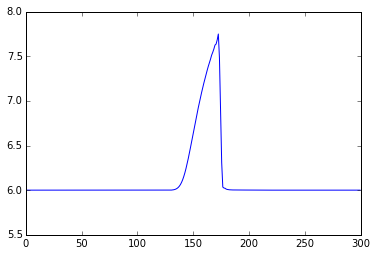

In [34]:
#--------------------------------
# Set up the constants
#--------------------------------
a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Height of the dune
s= 12.0            # Datum
beta = 0.01

#--------------------------------
# Set up the domain, BCs and ICs
#--------------------------------
import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

 # Gravitational constant
state.problem_data['grav'] = 9.8
state.problem_data['sea_level'] = 0.0

#--------------------------------
# Set up the bathymetry
#--------------------------------
z = np.zeros(nx)
# Eq 66 - Build the Gaussian Hump
z = np.array([(h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()
z_hydro = z.copy()

# Set up the inital state of the flow
shw_slvr = shallow_solver(domain)
u, surf,h = shw_slvr.run(zc,s)


if np.isnan(u).any():
    # Get the flow
    print u
    raise ValueError('Failed to calculate the flow')
#--------------------------------
# Initialize the sed transport 
#--------------------------------    
# Eq 57
qbedload = np.zeros(nx)
roe_speed = np.zeros(nx)
qbedload = a*u**b
flux = np.zeros(nx)

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 3000. # Runtime
dt = 0.1 # Time step size (s)
nt = int(simTime/dt)  # Number of time steps


#--------------------------------
# Set up the model reporting parameters
#--------------------------------
z0 = zc.copy() 
z600 = zc.copy() 
z2000 = zc.copy()
verts = []

extractionInterval = 100.
tsteps=[]
cntr = 0
#--------------------------------
#  Run the model
#--------------------------------
for n in range(1,nt):  
    zn = zc.copy() 
    for i in range(0,nx): #i=2

        zloc = get_stencil(zn,i-2,i+4)
        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload,i-2,i+4)
        if len(qloc)<>6:
            raise ValueError('Stencil is incorrect')
 
        # Determine the Upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out
    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        zc[i] = zn[i]-(1./(1.-nP))*dt/dx*(floc[1]-floc[0])
    
    bed_max_delta = np.max(np.abs(z_hydro - zc))
    
    # Apply the avalanche model
    zc,iterations = avalanche_model(dx,xc,zc)
    #zc = z_updated.copy()
    
    # Re-run the solver and updated the sediment transport
    # Check if the avalanche model was updated OR the bed changed greater than the threshold
    if iterations > 0 or bed_max_delta > 0.05:
        u, surf,h = shw_slvr.run(zc,s);
        qbedload = a*u**b
        z_hydro = zc.copy()
        
    cntr += 1
    if cntr == 1000:
        cntr = 0
        print('Time step {0} of {1} - bed_max_delta {2}'.format(n,nt,bed_max_delta))

plt.plot(xc,zc)
    

In [35]:
from weno import get_exact_solution
x_6000, z_a6000 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,6000.)

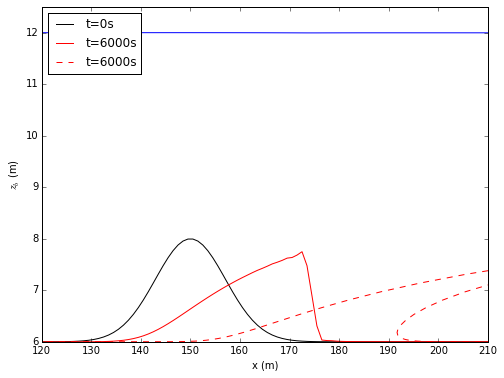

In [36]:
fig = plt.figure(figsize=(8, 6))
plt.plot(xc,z0,'k', label='t=0s') 

plt.plot(xc,zc, 'r', label='t=6000s')
plt.plot(x_6000, z_a6000,'r--', label='t=6000s')

plt.plot(xc, surf, 'b')

plt.xlabel('x (m)')
plt.ylabel('$z_b$ (m)')
plt.xlim([120,210])
plt.ylim([6,12.5])
plt.legend(loc=2)

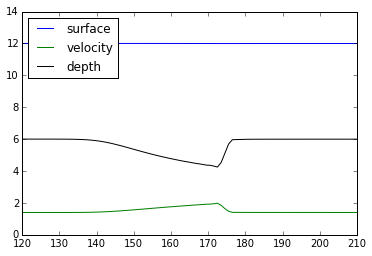

In [37]:
plt.plot(xc, surf, 'b', label='surface')
plt.plot(xc, u, 'g', label='velocity')
plt.plot(xc, h, 'k', label='depth')

plt.xlim([120,210])
plt.legend(loc=2)

## Run 2 - Meyer-Peter-Muller Sediment Transport Equations

Same as above but now we will swap the sediment transport equations from

$Q_{bedload} = aU^b$

to 


In [ ]:

import cython
%load_ext cython

In [87]:
%%cython
import sys
from clawpack import pyclaw
from clawpack import riemann
import numpy as np
import sed_trans

sys.path.append("/home/pgrover/Dropbox/PhD/Morphodynamic_Model/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil

from models.shallow_water_solver import shallow_solver
from schemes.avalanche_scheme import *


#--------------------------------
# Set up the constants
#--------------------------------
a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Height of the dune
s= 12.0         # Datum
beta = 0.01

# Sediment properties
D50 = 0.001     # Particle Diameter
rho_particule = 2650

#--------------------------------
# Set up the domain, BCs and ICs
#--------------------------------
import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

 # Gravitational constant
state.problem_data['grav'] = 9.8
state.problem_data['sea_level'] = 0.0

#--------------------------------
# Set up the bathymetry
#--------------------------------
z = np.zeros(nx)
# Eq 66 - Build the Gaussian Hump
z = np.array([(h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()
z_hydro = z.copy()

# Set up the inital state of the flow
shw_slvr = shallow_solver(domain)
u, surf,h = shw_slvr.run(zc,s)


if np.isnan(u).any():
    # Get the flow
    print u
    raise ValueError('Failed to calculate the flow')
#--------------------------------
# Initialize the sed transport 
#--------------------------------    
# Eq 57
qbedload = np.zeros(nx)
roe_speed = np.zeros(nx)
qbedload = a*u**b
flux = np.zeros(nx)

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 10000. # Runtime in seconds
dt = 2 # Time step size (s)
nt = int(simTime/dt)  # Number of time steps


#--------------------------------
# Set up the model reporting parameters
#--------------------------------
z0 = zc.copy() 
z600 = zc.copy() 
z2000 = zc.copy()
verts = []

extractionInterval = 100.
tsteps=[]
cntr = 0
#--------------------------------
#  Run the model
#--------------------------------
for n in range(1,nt):  
    zn = zc.copy() 
    for i in range(0,nx): #i=2

        zloc = get_stencil(zn,i-2,i+4)
        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload,i-2,i+4)
        if len(qloc)<>6:
            raise ValueError('Stencil is incorrect')
 
        # Determine the Upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out
    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        zc[i] = zn[i]-(1./(1.-nP))*dt/dx*(floc[1]-floc[0])
    
    bed_max_delta = np.max(np.abs(z_hydro - zc))
    
    # Apply the avalanche model
    zc,iterations = avalanche_model(dx,xc,zc)
    #zc = z_updated.copy()
    
    # Re-run the solver and updated the sediment transport
    # Check if the avalanche model was updated OR the bed changed greater than the threshold
    if iterations > 2 or bed_max_delta > 0.05:
        u, surf,h = shw_slvr.run(zc,s)
        for i in range(0,nx): #i=2    
            zlocal = get_stencil(zn,i-2,i+2)
            slope = (zlocal[3]-zlocal[1]) / dx
            qbedload[i] = sed_trans.get_unit_bed_load2(h[i],u[i],D50,rho_particule,'mpm') 
        z_hydro = zc.copy()
    
    if (n*dt / extractionInterval) == math.floor(n*dt / extractionInterval):
        verts.append(list(zip(xc.copy(),zc.copy())))
        tsteps.append(n*dt)
        
    cntr += 1
    if cntr == 1000:
        cntr = 0
        print('Time step {0} of {1} - bed_max_delta {2}'.format(n,nt,bed_max_delta))    
        
print('Done')

Grid dx = 1.0
Grid nx = 300
Time step 1000 of 5000 - bed_max_delta 0.0268039179195
Time step 2000 of 5000 - bed_max_delta 0.0117566954222
Time step 3000 of 5000 - bed_max_delta 0.00563652766038
Time step 4000 of 5000 - bed_max_delta 0.00892869454514
Done


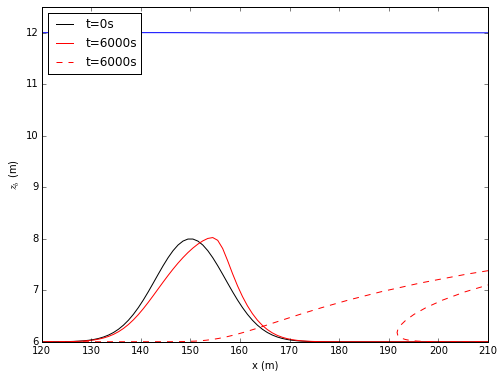

In [88]:
fig = plt.figure(figsize=(8, 6))
plt.plot(xc,z0,'k', label='t=0s') 

plt.plot(xc,zc, 'r', label='t=6000s')
plt.plot(x_6000, z_a6000,'r--', label='t=6000s')

plt.plot(xc, surf, 'b')

plt.xlabel('x (m)')
plt.ylabel('$z_b$ (m)')
plt.xlim([120,210])
plt.ylim([6,12.5])
plt.legend(loc=2)

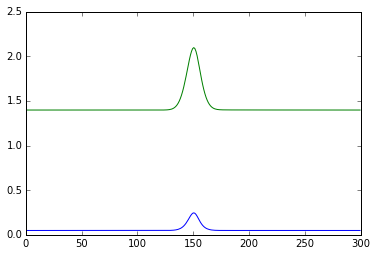

In [66]:
plt.plot(xc,qbedload*1000)
plt.plot(xc,u)


In [84]:
slope

1.7587782252803663e-07

## Now account for the influence of the bed slope on the sediment transport


In [1]:
#--------------------------------
# Set up the constants
#--------------------------------
a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Height of the dune
s= 12.0         # Datum
beta = 0.01

# Sediment properties
D50 = 0.001     # Particle Diameter
rho_particule = 1650

#--------------------------------
# Set up the domain, BCs and ICs
#--------------------------------
import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

 # Gravitational constant
state.problem_data['grav'] = 9.8
state.problem_data['sea_level'] = 0.0

#--------------------------------
# Set up the bathymetry
#--------------------------------
z = np.zeros(nx)
# Eq 66 - Build the Gaussian Hump
z = np.array([(h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()
z_hydro = z.copy()

# Set up the inital state of the flow
shw_slvr = shallow_solver(domain)
u, surf,h = shw_slvr.run(zc,s)


if np.isnan(u).any():
    # Get the flow
    print u
    raise ValueError('Failed to calculate the flow')
#--------------------------------
# Initialize the sed transport 
#--------------------------------    
# Eq 57
qbedload = np.zeros(nx)
roe_speed = np.zeros(nx)
qbedload = a*u**b
flux = np.zeros(nx)

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 20000. # Runtime in seconds
dt = 10 # Time step size (s)
nt = int(simTime/dt)  # Number of time steps


#--------------------------------
# Set up the model reporting parameters
#--------------------------------
z0 = zc.copy() 
z600 = zc.copy() 
z2000 = zc.copy()
verts = []

extractionInterval = 100.
tsteps=[]
cntr = 0
#--------------------------------
#  Run the model
#--------------------------------
for n in range(1,nt):  
    zn = zc.copy() 
    for i in range(0,nx): #i=2

        zloc = get_stencil(zn,i-2,i+4)
        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload,i-2,i+4)
        if len(qloc)<>6:
            raise ValueError('Stencil is incorrect')
 
        # Determine the Upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out
    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        zc[i] = zn[i]-(1./(1.-nP))*dt/dx*(floc[1]-floc[0])
    
    bed_max_delta = np.max(np.abs(z_hydro - zc))
    
    # Apply the avalanche model
    zc,iterations = avalanche_model(dx,xc,zc)
    #zc = z_updated.copy()
    
    # Re-run the solver and updated the sediment transport
    # Check if the avalanche model was updated OR the bed changed greater than the threshold
    if iterations > 10 or bed_max_delta > 0.01:
        u, surf,h = shw_slvr.run(zc,s)
    # Remove the old method 
    #qbedload = a*u**b

    for i in range(0,nx): #i=2        
        qbedload[i] = sed_trans.get_unit_bed_load2(h[i],u[i],D50,rho_particule,'mpm')
    z_hydro = zc.copy()
    
    if (n*dt / extractionInterval) == math.floor(n*dt / extractionInterval):
        verts.append(list(zip(xc.copy(),zc.copy())))
        tsteps.append(n*dt)
        
    cntr += 1
    if cntr == 1000:
        cntr = 0
        print('Time step {0} of {1} - bed_max_delta {2}'.format(n,nt,bed_max_delta))    
        
print('Done')

NameError: name 'pyclaw' is not defined

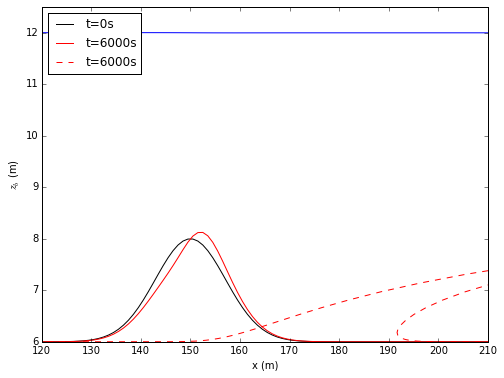

In [33]:
fig = plt.figure(figsize=(8, 6))
plt.plot(xc,z0,'k', label='t=0s') 

plt.plot(xc,zc, 'r', label='t=6000s')
plt.plot(x_6000, z_a6000,'r--', label='t=6000s')

plt.plot(xc, surf, 'b')

plt.xlabel('x (m)')
plt.ylabel('$z_b$ (m)')
plt.xlim([120,210])
plt.ylim([6,12.5])
plt.legend(loc=2)

In [96]:
from sed_trans import get_unit_bed_load_slope

ImportError: cannot import name get_unit_bed_load_slope